# MERGE Downloader

<b>Basic Usage</b><br>
This notebook shows the basic usage of the `merge-downloader` package.<br>
At version 0.1.1, this package manages to download from INPE the following files:
* Daily Rain files from MERGE model (.GRIB2)
* Climatology files in netCDF4 format (.nc)
    * Daily Average
    * Monthly Accumulated
    * Monthly Accumulated Yearly

In addition to the aforementioned files, it is possible to create Monthly Accumulated values from the Daily Rain, as INPE does not provide the averages up to date to the current year. 

Additionally, the package makes it easier for data cubes creation and time series generation in specific areas (given by .shp files)

<b>Custom Structures</b><br>
Currently, the files are located at `ftp.cptec.inpe.br`, in the following folder `/modelos/tempo/MERGE/GPM/`

However, the package can be easily extended by configuring new custom parsers, as explained in notebook `04-CustomParser.ipynb`


## Initialization

To create a `Downloader` instance, we need to pass the FTP URL and the Parsers we want to work with. All INPE parsers are combined in a list called `INPEParsers.parsers`

In [3]:
%load_ext autoreload
%autoreload 2

from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import INPEParsers, INPETypes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Create a downloader instance
downloader = Downloader(
    server=INPEParsers.FTPurl, 
    parsers=INPEParsers.parsers, 
    local_folder='/workspaces/reports_folder/downloads/'
)

Each `parser` is responsible for dealing with a specific data type. Depending on the desired data type, the request will be dispached to the corresponding parser. After initialization, to get the list of data types available, we can access the attribute `.data_types`

In [3]:
for data_type in downloader.data_types:
    print(data_type.name)

DAILY_RAIN
MONTHLY_ACCUM_YEARLY
DAILY_AVERAGE
MONTHLY_ACCUM
MONTHLY_ACCUM_MANUAL
YEARLY_ACCUM
HOURLY_WRF
DAILY_WRF


## Download a single file

To download a single file, we can simply pass the date in any format that dateutil can parse.<br>
For example: 'yyyy-mm-dd', 'yyyymmdd', 'yyyy/mm/dd', etc.<br>

Additionally, we pass the Data Type we want the the output folder.

In [4]:
# download the rain of 1st of March 2023
file = downloader.download_file('2023-03-01', datatype=INPETypes.DAILY_RAIN)
assert file.exists()

file

PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230301.grib2')

<b>NOTE 1: </b> A file structure is automatically created within the specified local folder (`local_folder`). 

<b>NOTE 2: </b> One should keep in mind that the rain from 9:00am from 2023/03/01 to 9:00 from 2023/03/02 is saved as 20030302 but it is actually the amount of rain in 20230301.


### `get_file`


Instead of `download_file` we can also use the most general function `get_file`. In this case, before downloading, we check if the file exists and if it is exactly the same (size and modified dates). If the file is the same we don't download it again, unless `force` is set to True. As this checking takes time, an attribute of the downloader called `avoid_update` can be set to `True` to bypass this check.

In [5]:
file = downloader.get_file('2023-03-01', datatype=INPETypes.DAILY_RAIN)
file

PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230301.grib2')

## Download a range

Similar to get a file, we can download a range by passing start and end dates...


In [6]:
files = downloader.get_range(
    start_date='20230301', 
    end_date='20230305', 
    datatype=INPETypes.DAILY_RAIN,
    force_download=False
)

# assert files exist
for file in files:
    assert file.exists()

# list the files
files

[PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230301.grib2'),
 PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230302.grib2'),
 PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230303.grib2'),
 PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230304.grib2'),
 PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230305.grib2')]

## Post Processing

INPE files comes in different formats, projections, etc. To make things easier for further analysis, we can put them in the same CRS at the time of opening. For that, we use `post_processors`. These are functions that are applied when opening the files to make them conform with each other. 

These processors receive and return XArray Datasets. Each parser has it's own `post_processor` associated at initialization time through the `post_proc` argument.

The `post_proc` is optional and it will be used, if not `None` by the `open_file` method from the parser. <br>
To exemplify, let's check the `post_processor` associated with the Daily Rain parser. 

In [7]:
daily_parser = INPEParsers.parsers[0]
daily_parser

Parser instance: DAILY_RAIN

In [8]:
daily_parser.post_proc??

Signature: daily_parser.post_proc(dset: xarray.core.dataset.Dataset, **_) -> xarray.core.dataset.Dataset
Source:   
    @staticmethod
    def grib2_post_proc(dset: xr.Dataset, **_) -> xr.Dataset:
        """Adjust the longitude in INPE's grib2 files and sets the CRS"""

        dset = dset.assign_coords({"longitude": dset.longitude - 360})
        dset = dset.rio.write_crs("epsg:4326")
        return dset
File:      /workspaces/merge-downloader/mergedownloader/inpeparser.py
Type:      function

In [9]:
file = daily_parser.get_file('20230501', '/workspaces/reports_folder/downloads/')
file

PosixPath('/workspaces/reports_folder/downloads/DAILY_RAIN/MERGE_CPTEC_20230501.grib2')

In [10]:
import xarray as xr
xr.open_dataset(file)

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-06-26T14:59 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
rain = daily_parser.open_file('20230501', '/workspaces/reports_folder/downloads/')
rain

<xarray.Dataset>
Dimensions:      (latitude: 924, longitude: 1001)
Coordinates:
    time         datetime64[ns] ...
    step         timedelta64[ns] ...
    surface      float64 ...
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time   datetime64[ns] ...
    spatial_ref  int64 0
Data variables:
    prec         (latitude, longitude) float32 ...
    prmsl        (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-06-26T14:59 GRIB to CDM+CF via cfgrib-0.9.1...

One can see the difference between the results in the longitude coordinates. When the `parser` opens the file, it applies the post processing automatically. 

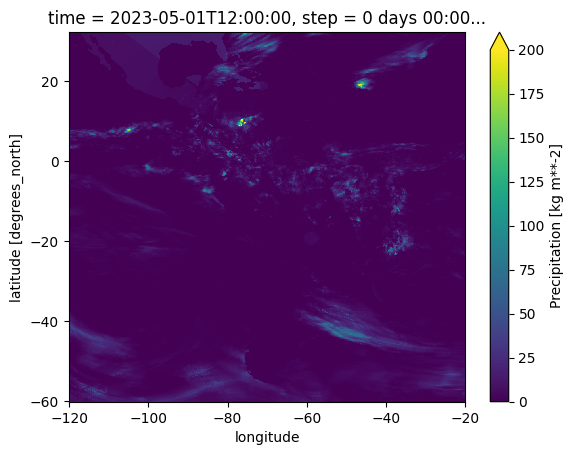

In [12]:
# plot the array
rain['prec'].plot(vmax=200)

### Type-specific Post Processor

Additionally, data types can also have specific post processors, that goes into the Parser. for example, for Yearly Accumulated, the Parser has a post processor to correct the date. To make sure you are opening a file with the processors applied, make sure to open the files using the `.open_file()` method.

In [13]:
downloader.get_parser(INPETypes.YEARLY_ACCUM).post_proc

<function mergedownloader.inpeparser.INPE.yearly_post_proc(dset: xarray.core.dataset.Dataset, date_str, **_) -> xarray.core.dataset.Dataset>

In [14]:
rain = downloader.open_file('2002', datatype=INPETypes.YEARLY_ACCUM)
rain

<xarray.DataArray 'pacum' (time: 1, latitude: 691, longitude: 474)>
[327534 values with dtype=float64]
Coordinates:
  * longitude    (longitude) float64 -81.95 -81.85 -81.75 ... -34.75 -34.65
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
  * time         (time) datetime64[ns] 2002-01-01
    spatial_ref  int64 0

## Cube Creation

To create a cube, it is enough to pass initial and final dates and the desired data type. For example, let's create a cube with thain rain in the first 7 days of March 2023 and stack them in the `time` dimension.

In [15]:
cube = downloader.create_cube(
    start_date='20230301', 
    end_date='20230307', 
    datatype=INPETypes.DAILY_RAIN,
    force_download=False,
    dim_key='time'
)

In [16]:
cube.time.values

array(['2023-03-01T12:00:00.000000000', '2023-03-02T12:00:00.000000000',
       '2023-03-03T12:00:00.000000000', '2023-03-04T12:00:00.000000000',
       '2023-03-05T12:00:00.000000000', '2023-03-06T12:00:00.000000000',
       '2023-03-07T12:00:00.000000000'], dtype='datetime64[ns]')

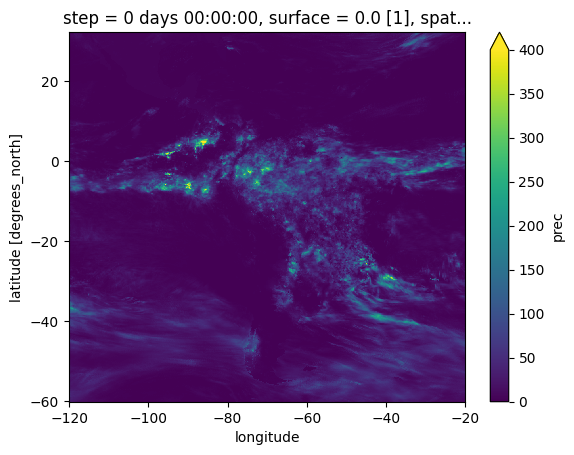

In [17]:
# To calculate the total rain in this period...
cube.sum(dim=['time']).plot(vmax=400)

## Downloading Climatology

Besides the Daily Rain, it is also possible to download <b>Climatology</b> data that refers to information about the long-term patterns and trends of climate.

The process is exacly the same as before, we just specify the data type we want. Currently the supported parsers are:



In [18]:
downloader.data_types

[<INPETypes.DAILY_RAIN: {'id': <enum.auto object at 0xffff606adfc0>, 'var': 'prec', 'name': 'Daily Rain'}>,
 <INPETypes.MONTHLY_ACCUM_YEARLY: {'id': <enum.auto object at 0xffff606acbe0>, 'var': 'pacum', 'name': 'Monthly Accumulated Yearly'}>,
 <INPETypes.DAILY_AVERAGE: {'id': <enum.auto object at 0xffff606acbb0>, 'var': 'pmed', 'name': 'Daily Average'}>,
 <INPETypes.MONTHLY_ACCUM: {'id': <enum.auto object at 0xffff606acb50>, 'var': 'precacum', 'name': 'Monthly Accumulated'}>,
 <INPETypes.MONTHLY_ACCUM_MANUAL: {'id': <enum.auto object at 0xffff606acb80>, 'var': 'monthacum', 'name': 'Monthly Accumulated Yearly'}>,
 <INPETypes.YEARLY_ACCUM: {'id': <enum.auto object at 0xffff606aca60>, 'var': 'pacum', 'name': 'Year Accumulated'}>,
 <INPETypes.HOURLY_WRF: {'id': <enum.auto object at 0xffff606acac0>, 'var': 'hour_wrf', 'name': 'Hourly Forecast (7day model)'}>,
 <INPETypes.DAILY_WRF: {'id': <enum.auto object at 0xffff606acaf0>, 'var': 'forecast', 'name': 'Daily Forecast (7day model)'}>]

For the climatology data that is available only in monthly basis, we can specify the date with day (e.g., '20230101' or '2023-01-01'), or we can pass only the year and month (e.g., '2023-01' or '2022-04')

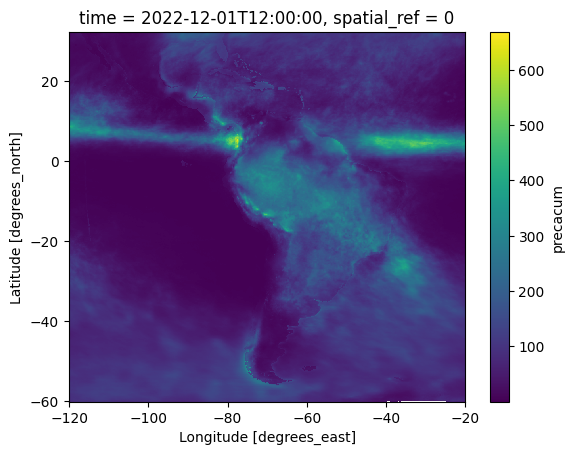

In [19]:
# Downloading the Long Term Average of december
lta = downloader.open_file('2023-12', datatype=INPETypes.MONTHLY_ACCUM)

lta.plot()

<b>Note:</b> Note that we can pass any year in the date, as we have only 12 files, one for each month. <br>

Now, let's download the rain for december 2022.

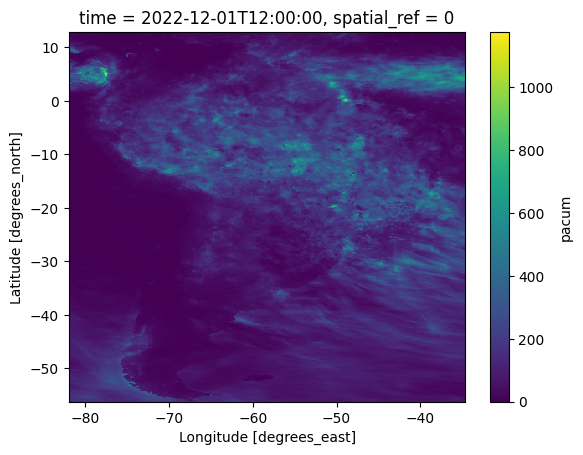

In [20]:
# Downloading the total accumulated rain for december 2022
lta = downloader.open_file('2022-12', datatype=INPETypes.MONTHLY_ACCUM_YEARLY)

lta.plot()

## Accumulating Monthly Rain Manually

We can see that in the yearly accumulated rain, the resolution is not the same. Moreover if we take a look at the source directory from INPE, the accumulated rain is not calculated for 2023 yet. 

Check `http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/`

For this scenario, our package is able to calculate the Monthly Accumulated "Manually". We just need to ask for this data type, like so:


In [21]:
may = downloader.open_file('2023-02', datatype=INPETypes.MONTHLY_ACCUM_MANUAL)

may.plot(vmax=1000)

For this, we download all the Daily Rain files for the specified month and calculate total rain and save the accumulated rain raster to MONTHLY_ACCUM_MANUAL folder. 